На этом семинаре мы посмотрим на то, что можно сделать с большими данными, когда у нас есть большие вычислительные мощности, но не в виде кластера, а в виде одной большой машины.

На Azure нужно будет поднять самую жирную тачку, что вы сможете там найти - сегодня ни в чем себе не отказываем и будем ворочать алгоритмы сразу в памяти.

```
# get link from this site - https://www.anaconda.com/distribution/

wget https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh -O install-conda.sh
chmod +x install-conda.sh
./install-conda.sh

# add conda to PATH

eval "$(/sshuser/anaconda3/bin/conda shell.bash hook)" 
conda init

jupyter notebook --ip=0.0.0.0 --NotebookApp.token=
```

## Поиск ближайших

Сформулируем задачу следующим образом: имеется большой набор объектов, описываемых векторами R^n; требуется построить такую структуру данных, которая по вектору R^n (объекту, называемому запросом) вернет K ближайших (по некоторой метрике, i.e. L2, cosine) объектов из набора.

Таким образом, имеем исходную параметризацию: размер набора, размер пространства представления (n), размер ответа (K), метрика.

Задачу можно решать как точно, так и приблизительно, разменивая точность на скорость.

В качестве данных используем mnist 8m.

In [ ]:
! wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/mnist8m.bz2
! bzip2 -vd mnist8m.bz2

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.datasets import load_svmlight_file
from sklearn.neighbors import BallTree

Для семинара отрежем семпл, чтобы не ждать особенно долго.

In [2]:
! head -n 50000 mnist8m > mnist_sample

In [3]:
X, y = load_svmlight_file('mnist_sample', n_features=784)

In [4]:
X = X / 255  # отмасштабируем

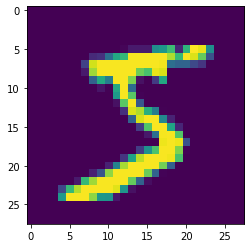

In [5]:
plt.imshow(X[0].reshape(28, 28).toarray())

Итого, у нас целая куча картинок. Наша задача - по полученной картинке найти самые похожие на нее.

Каждая картинка в нашем случае - это просто вектор из R^784. Таким образом будем пытаться искать близкие между собой вектора по какой-то метрике. 

Note: искать в пространстве пикселей может быть не самой разумной идеей - можно получить гораздо более качественные результаты, если предобработать сырые данные (посчитать какие-то умные фичи по картинке, например), однако в конце остается задача - как по вектору из R^d искать близкие к нему. Именно эту задачу мы и попытаемся решить. Вопрос эмбединга исходных данных остается за рамками этого курса, поэтому для наших целей исходные данные вполне подойдут.


# Ball Tree

Одним из простых и понятных алгоритмов поиска ближайших соседей в метрическом пространстве является алгоритм Ball Tree.

Идея буквально следующая - разделить все пространство объектов на подобласти, чтобы при поиске ответа необходимо было искать лишь в ограниценных подобластях, а не среди всех объектов.

Простая версия алгоритма Ball Tree строит бинарное дерево, где каждый узел отвечает за свою сферу (гиперсферу), внутри которой находятся другие подсферы. В узлах дерева находятся уже исходные элементы.

Схема построения следующая:
* В корне помещаем одну гиперсферу, которая вмещает в себя вообще все элементы
* После этого на каждом уровне будем разделять элементы внутри гиперсферы на две группы и накрывать их гиперсферами поменьше
  * Самый простой алгоритм разделения ищет точку X - самая дальняя точка от центра текущей сферы, точку Y - самую дальнюю точку от X и далее делит на две группы в зависимости от того к какой точке ближе - X или Y
  * Более продвинутая версия алгоритма считает главные компоненты и делит множество поровну вдоль оси первой главной компоненты - то есть вдоль оси с наибольшей дисперсией.
* Критерии остановки могут быть разными - глубина дерева, количество оставшихся элементов и тд.

<img src="img/ball-tree-construct.png" width="500">

На рисунке алгоритм определил A и B как самые удаленные точки и относительно них разбил на два подмножества и накрыл их сферами

<img src="http://stevehanov.ca/blog/balltree.png">

Поиск точки близкой по радиусу практически тривиален:
* Нам дается точка `x` и радиус `r`. Мы смотрим на гиперсферу `s`. Если `radius(s) + r > |center(s) - x|`, то это означает, что сфера поиска и наша сфера в дереве не пересекаются, а значит в этой сфере нет смысла искать соседей. Если же `radius(s) + r <= |center(s) - x|`, то сферы пересекаются, значит там могут быть соседи. 
* Используя этот критерий, спускаемся по дереву вниз - когда добираемся до листов просто проверяем все элементы в этом листе на близость к `x`. 
* Возвращаем все те, которые были близко. 

<img src="img/ball-tree-search.png" width="1000">

Итого, дерево позволяет относительно быстро искать соседей (в смысле L2 меры) для заданного радиуса.

Более подробно о структуре данных можно почитать здесь - https://www.researchgate.net/publication/283471105_Ball-tree_Efficient_spatial_indexing_for_constrained_nearest-neighbor_search_in_metric_spaces 

Реализовывать самостоятельно мы его не будем - просто воспользуемся реализацией из sklearn.

In [7]:
%time
tree = BallTree(X.toarray())

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [23]:
def find_nn_ball_tree(index):
    plt.figure()
    plt.imshow(X[index].reshape(28, 28).toarray())
    
    result = tree.query_radius(np.array(X[index].toarray()), r=7)
    print("Neighbours count: ", len(result[0]))
    for nn_index in result[0][:5]:
        plt.figure()
        plt.imshow(X[nn_index].reshape(28, 28).toarray())

Neighbours count:  48


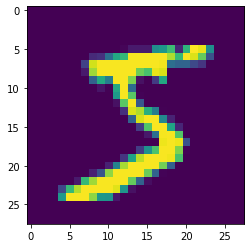

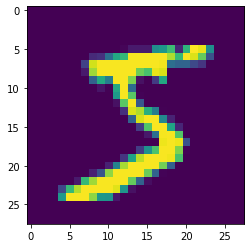

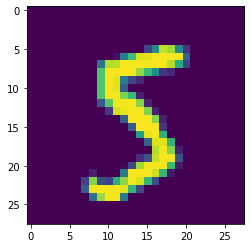

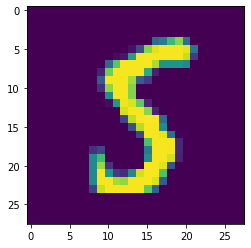

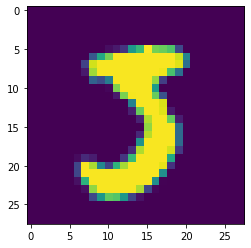

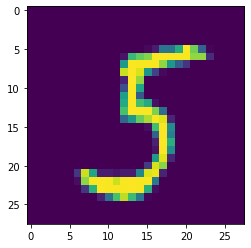

In [24]:
find_nn_ball_tree(0)

Neighbours count:  313


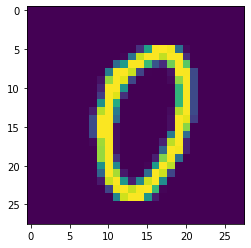

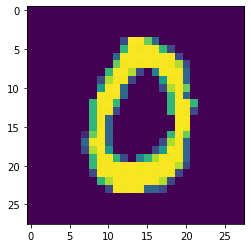

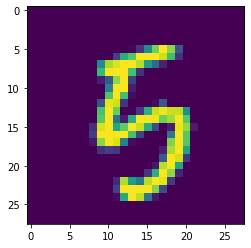

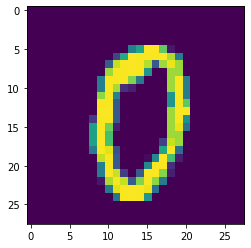

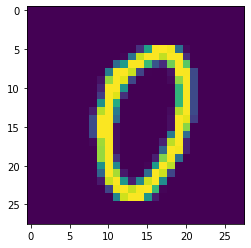

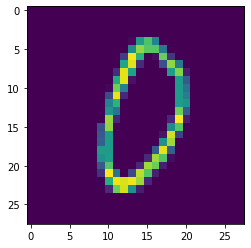

In [25]:
find_nn_ball_tree(1000)

Neighbours count:  11829


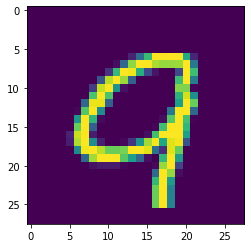

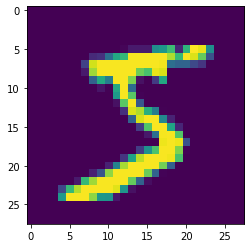

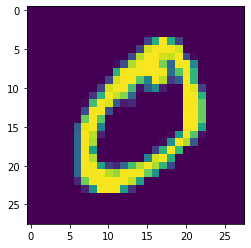

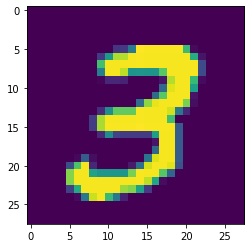

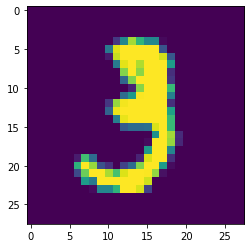

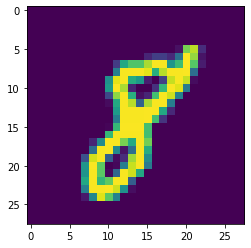

In [72]:
find_nn_ball_tree(3000)

Что ж, кажется, что поиск с радиусом 7 дает вполне осмысленные результаты даже на сырых пикселях!

Однако даже на таком количестве данных такой алгоритм начинает проседать по производительности (попробуйте построить ball tree на всех 8 миллионах). Однако алгоритм всегда выдает корректный (честный) ответ.

Попробуем пойти другим путем и разменять точность ответа на производительность.

# LSH - Locality-sensitive hashing

Интуиция из классических алгоритмов подсказывает нам, что для того чтобы искать очень быстро нужно строить хеш-таблицу. 

Именно этим мы и попытаемся заняться. В идеале мы бы хотели построить хеш с таким свойством, что у близких элементов он бы совпадал. Тогда если мы сложим их в хеш-таблицу, то по одному ключу мы сразу вычислим всех соседей. 

Для того чтобы построить такой хеш, посмотрим немного на R^2.

<img src="img/lsh-1.png">

На картинке у нас есть w_1 - базисный вектор (1, 0) и 6 векторов для примера.

Несложный факт из линейной алгебры: скалярное произведение <x, y> в общем случае - это произведение длины вектора x на длину проекции y на вектор x.

<img width="300" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/Scalar-product-dot-product.svg/1280px-Scalar-product-dot-product.svg.png">

В случае с базисным вектором w_1 ситуация еще проще - это просто длина проекции на ось Х.

Используя это знание попробуем сконструировать хеш следующего вида

`h(x) = ⌊<x, w_1>⌋` (округляем вниз).

Можно заметить, что все элементы, у которых координата x была в пределах [0, 1] будут иметь один и тот же хеш = 0. Все элементы, у которых x координата в [1, 2] получают одинаковый хеш = 1 и так далее. Другими словами все множество разбивается на такие группы (бакеты) в виде полос (на рисунке показаны две полосы - синяя и серая).

Уже в такой простой постановке хеш может быть полезен. Близкие между собой элементы x_1 и x_2 имеют один и тот же хеш, также как и элементы x_5, x_4.

Однако на картинке сразу видно несколько проблем:
* x_6 находится далеко от x_1, однако имеет с ним такой же хеш.
* x_3 находится близко от x_2, однако они имеют различный хеш.

Давайте их решим. 

Первую проблему можно решить достаточно несложным образом - добавим второй базисный вектор w_2 и под хешом будем уже понимать пару чисел: `h(x) = (⌊<x, w_1>⌋, ⌊<x, w_2>⌋)`

<img src="img/lsh-2.png">

Видно, что теперь мы поделили пространство уже не на полосы, а на квадраты, которые задают нам базисные вектора.

Теперь x_1 и x_2 все еще имеют одинаковый хеш = (0, 0) (так же как и x_5 и x_4 с хешом (1, -1)), а вот x_1 и x_6 больше нет - h(x_1) = (0, 0), h(x_6) = (0, 2).

Чтобы решить вторую проблему, мы можем немного подвигать сетку, которая у нас получилась, таким образом, чтобы в подвинутой сетке x_2 и x_3 все таки попали в одну клетку. Для этого нужно завести еще хеш.

`h_2(x) = (⌊<x, w_1> + 0.5⌋, ⌊<x, w_2>⌋)`

<img src="img/lsh-3.png">

Отлично! Видно, что теперь x_2 и x_3 будут иметь одинаковый хеш. Интересно отметить, что после сдвига x_5 и x_4 имеют различных хеш.

Таким образом для поиска всех соседей потребуется искать соседей по двум хешам - h и h_2.

Необходимо также заметить, что мы сдвинули сетку только по оси x. По оси Y у нас присутствует та же проблема, которую можно решить таким же способов. Легко понять, что для размерности 2, нам потребуется 4 хеша.

* `h_1 = (⌊<x, w_1>⌋, ⌊<x, w_2>⌋)`
* `h_2 = (⌊<x, w_1> + 0.5⌋, ⌊<x, w_2>⌋)`
* `h_3 = (⌊<x, w_1>⌋, ⌊<x, w_2> + 0.5⌋)`
* `h_4 = (⌊<x, w_1> + 0.5⌋, ⌊<x, w_2> + 0.5⌋)`

Отлично! Построив 4 таблицы мы можем за константу находить элементы, которые находятся друг от друга на расстоянии меньше 1.

Что делать, если хотим искать с другим радиусом r?

Для этого на самом деле достаточно просто увеличить сетку в r раз - или, что тоже самое, сжать все вектора в r раз. Единственное - необходимо быть аккуратным и сдвигать теперь не на 0.5 а на половину радиуса.

Итого, для радиуса r:

* `h_1 = (⌊<x, w_1> / r⌋, ⌊<x, w_2> / r⌋)`
* `h_2 = (⌊(<x, w_1> + 0.5 * r) / r⌋, ⌊<x, w_2> / r⌋)`
* `h_3 = (⌊<x, w_1> / r⌋, ⌊(<x, w_2> + 0.5 * r) / r⌋)`
* `h_4 = (⌊(<x, w_1> + 0.5 * r) / r⌋, ⌊(<x, w_2> + 0.5 * r) / r⌋)`

Кажется, что критических проблем более не наблюдается. Для R^2 алгоритм будет выглядеть так

* Берем 4 хеша и строим по ним хеш-таблицы для всех элементов
* Когда к нам приходит запрос считаем все 4 хеша и ищем во всех таблицах элементы.
* Дополнительно нужно выкинуть элементы, которые дальше от нашего элемента чем на r. Такое может случиться, так как внутри квадрата элементы могут находится на расстоянии sqrt(2) * r. 

Готово, мы нашли всех соседей, причем наш ответ честный. 

Однако, что произойдет, когда нам потребуется решить эту задачу в R^n, где n - большое.

Если следовать описанной схеме, то нам потребуется взять 2^n хешей, внутри которых будет n элементов. Итого `2^n * n` - это очень много и использовать такую схему as-is крайне непрактично. Эту проблему нам помогут обойти вероятностные трюки.

Предлагается сделать буквально следующее - накидать случайных сеток на пространство таким образом, чтобы вероятность успеха была хорошей. Итого для R^n:

* `h_1 =(⌊(<x, w_11> + b_11) / r⌋, ⌊(<x, w_12> + b_12) / r⌋, ..., ⌊(<x, w_1k> + b_1k) / r⌋ )`
* `h_2 =(⌊(<x, w_21> + b_21) / r⌋, ⌊(<x, w_22> + b_22) / r⌋, ..., ⌊(<x, w_2k> + b_2k) / r⌋ )`
* `...`
* `h_d =(⌊(<x, w_d1> + b_d1) / r⌋, ⌊(<x, w_d2> + b_d2) / r⌋, ..., ⌊(<x, w_dk> + b_dk) / r⌋ )`

`k` - размерность хеша, k < n. `d` - количество хешей, d < 2^n. При этом: `w_ij`- случайный вектор размера n, `b_ij` - случайное число.

Осталось только выбрать параметры так, чтобы вероятность успеха была хорошей. Перед этим неплохо бы понять, что такое вероятность успеха. 

Легко видеть, что у нас могут возникать две проблемы
* Мы можем найти элемент, который на самом деле далеко от нас
* Мы можем не найти элемент, который на самом деле близко от нас

Итого, у нас есть две вероятности - вероятность того, что найденный элемент близок к нам (`alpha_probability`) и вероятность того, что близкий элемент не был нами найден (`beta_probability`). 

Математика утверждает следующее:

Для фиксированных вероятностей `alpha_probability`, `beta_probability`, радиуса `r`, выборки данных размера `M` из `R^n` и меры расстояния `L2`:
* `w_ij` - случайный вектор из нормального распределения `N(0, 1)`
* `b_ij` - случайное число из равномерного распределения `U[0, r]`
* 
```
rho = ln(1/alpha_probability) / ln(1/beta_probability)
k = ceil( ln(M) / ln( 1/beta_probability ) )
d = ceil( 2 * M^rho )
```

Более подробно с алгоритмом можно ознакомиться здесь - https://arxiv.org/pdf/1408.2927.pdf

**Задача**
* Реализовать LSH для L2. Посчитать его на датасете и сравнить результаты с Ball Tree. `find_nn` должна вернуть сами элементы. `find_and_print_nn` должна вести себя как `find_nn_ball_tree` - она ищет ближайшие, печатает количество найденных, рисует картинку, которую искали и пять соседей. (Запускать минимум на полумиллионе записей. При запуске на всех данных - доп балл.)

In [36]:
# DO IT
class L2LSH():
    def __init__(self, data, radius, alpha_probability=0.9, beta_probability=0.1):
        self._img = data[0]
    
    def find_nn(self, element, k=5):
        return [self._img]
    
    def find_and_print_nn(self, element):
        plt.figure()
        plt.imshow(element.reshape(28, 28).toarray())

        result = self.find_nn(element)
        print("Neighbours count: ", len(result))
        for nn in result[0][:5]:
            plt.figure()
            plt.imshow(nn.reshape(28, 28).toarray())

Neighbours count:  1


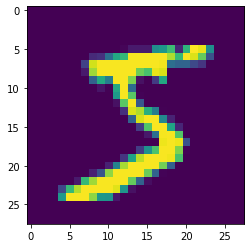

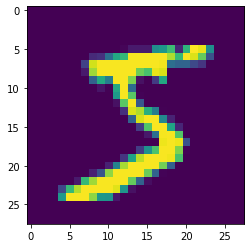

In [33]:
lsh = L2LSH(X, 7)
lsh.find_and_print_nn(X[0])

Neighbours count:  1


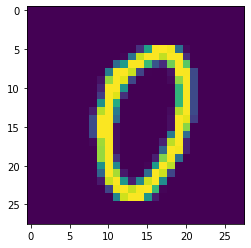

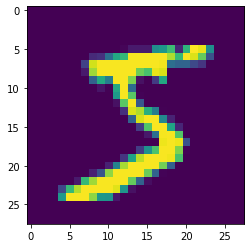

In [34]:
lsh.find_and_print_nn(X[1000])

Neighbours count:  1


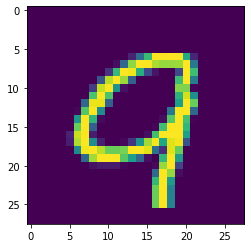

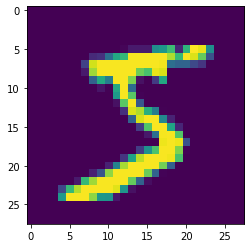

In [71]:
lsh.find_and_print_nn(X[3000])

# LSH для cosine similarity

L2 - не всегда удачная метрика близости. Часто вместо нее используют cosine метрику, которая учитывает только угол между векторами. Как искать вектора, близкие в смысле коллинеарности?

Для этого мы можем провернуть похожий трюк с хешированием и построить LSH для cosine. Рассуждения будут очень похожими.

Note: `cosine(x, y) = 1 - cos(x, y)`

Элементарный хеш будет строится следующий образом

`h(x) = sign(<x, w>)`

Составной хеш будет строится аналогично 

`h_1(x) = (sign(<x, w_1>), sign(x, w_2))`

Если в качестве w_1 и w_2 взять базисные вектора, то картина будет примерно следующей

<img src="img/lsh-4.png">

Знак скалярного произведения показывает, "смотрят ли" вектора в одну сторону. Таким образом один вектор делит пространство на две части прямой (гиперплоскостью в общем случае), перпендикулярной этому вектору.

Таким образом, если за `w_i` брать базисные вектора, то одинаковый хеш будут иметь те вектора, которые находятся в одной координатной четверти, что в соотносится с тем, что мы хотели. Такие вектора могут отличатся по L2 на любое расстояние, однако угол между ними не может быть больше 90 градусов (а значит и по косинусу они достаточно близки).

Проблемы при таком построении примерно такие же, как и для L2 и решать их предлагается такими же способами: накидываем случайных сеток.

* `h_1 =(sign(<x, w_11>), sign(<x, w_12> ), ..., sign(<x, w_1k>) )`
* `h_1 =(sign(<x, w_21>), sign(<x, w_22> ), ..., sign(<x, w_2k>) )`
* `...`
* `h_d =(sign(<x, w_d1>), sign(<x, w_d2>), ..., sign(<x, w_dk>) )`

`k` - размерность хеша, k < n. `d` - количество хешей, d < 2^n. При этом: `w_ij`- случайный вектор из `N(0, 1)` размера n.

Более подробно с алгоритмом можно ознакомиться здесь - https://www.hpl.hp.com/techreports/2007/HPL-2007-192R1.pdf

<img src="img/lsh-5.png">

**Задача**
* Реализовать LSH для cosine. Посчитать его на датасете и сравнить результаты с стандартной реализацией поиска ближайших соседей в sklearn (смотри код ниже). `find_nn` должна вернуть сами элементы. `find_and_print_nn` должна вести себя как `find_nn_ball_tree` - она ищет ближайшие, печатает количество найденных, рисует картинку, которую искали и пять соседей. (Запускать минимум на полумиллионе записей. При запуске на всех данных - под балл.)
* Параметры `k` и `d` предлагается получать при инициализации. Необходимо попробовать несколько возможных значений и посмотреть, как от этого зависит качество и скорость работы - посчитать precision и recall считая результаты ball tree истиной , время работы (сравним с ball tree) и субъективную оценку в свободной форме, насколько хорошо получилось.

In [40]:
from sklearn.neighbors import NearestNeighbors

In [41]:
neigh = NearestNeighbors(metric='cosine')
neigh.fit(X.toarray())

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [61]:
def find_nn_sklearn(index):
    plt.figure()
    plt.imshow(X[index].reshape(28, 28).toarray())
    
    result = neigh.radius_neighbors(np.array(X[index].toarray()), 0.3)
    print("Neighbours count: ", len(result[1][0]))
    for nn_index in result[1][0][:5]:
        plt.figure()
        plt.imshow(X[nn_index].reshape(28, 28).toarray())

Neighbours count:  204


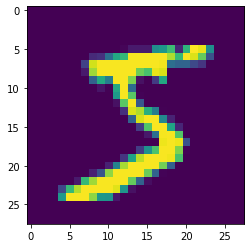

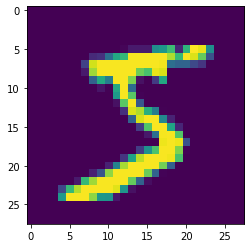

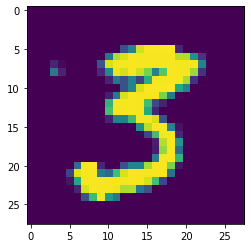

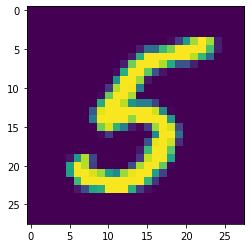

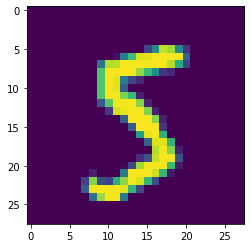

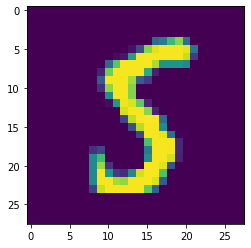

In [62]:
find_nn_sklearn(0)

Neighbours count:  578


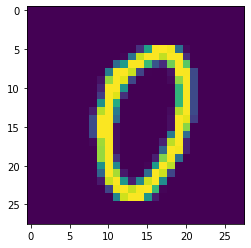

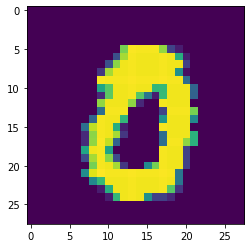

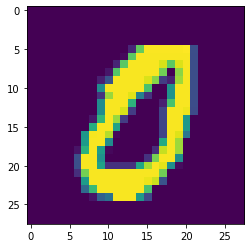

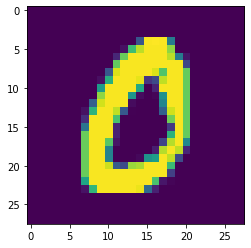

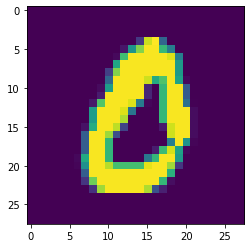

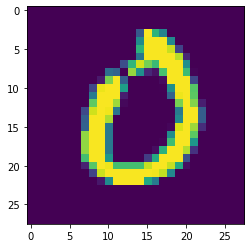

In [63]:
find_nn_sklearn(1000)

Neighbours count:  86


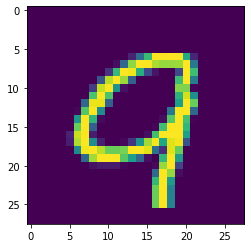

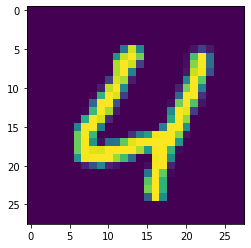

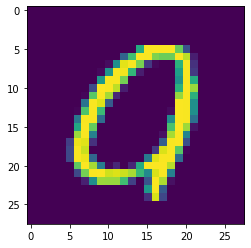

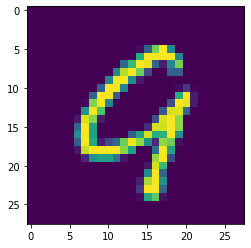

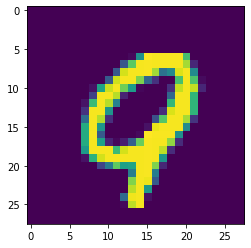

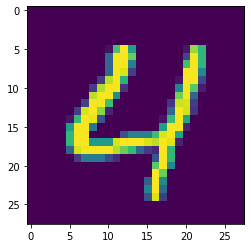

In [70]:
find_nn_sklearn(3000)

In [65]:
class CosineLSH():
    def __init__(self, data, radius, k=10, d=5):
        self._img = data[0]
    
    def find_nn(self, element):
        return [self._img]
    
    def find_and_print_nn(self, element):
        plt.figure()
        plt.imshow(element.reshape(28, 28).toarray())

        result = self.find_nn(element)
        print("Neighbours count: ", len(result))
        for nn in result[0][:5]:
            plt.figure()
            plt.imshow(nn.reshape(28, 28).toarray())

Neighbours count:  1


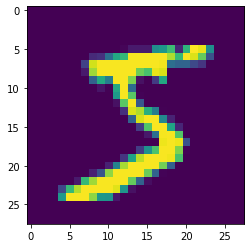

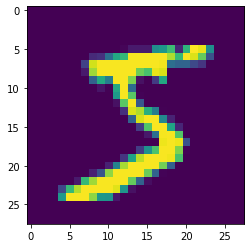

In [66]:
lsh = CosineLSH(X, 7)
lsh.find_and_print_nn(X[0])

Neighbours count:  1


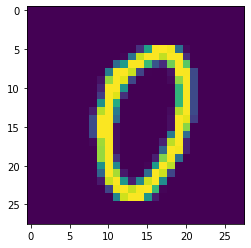

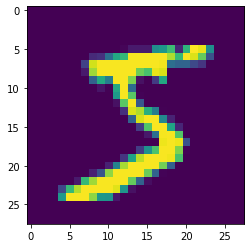

In [67]:
lsh.find_and_print_nn(X[1000])

Neighbours count:  1


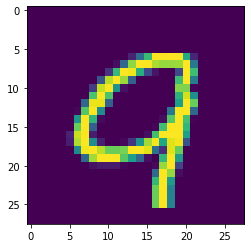

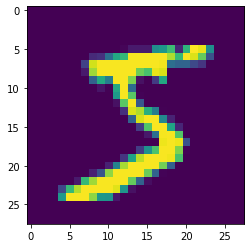

In [69]:
lsh.find_and_print_nn(X[3000])

## K-Means

Заметим, что в случае с LSH мы некоторым образом кластеризировали данные, а затем искали ближайших в полученных кластерах. На самом деле существует множество комбинаций алгоритмов кластеризации и построения индекса на результате для поиска ближайших.

Сейчас поговорим про кластеризацию: самым популярным методом кластеризации для L2 метрики является k-means. Можно отметить, что он очень хорошо ложится на парадигму MapReduce.

Алгоритм очень прост: мы задаём количество кластеров, на которое хотим поделить данные, а затем итеративно обновляем центры кластеров с целью минимизировать суммарное квадратичное отклонение точек кластеров от этих центров:

![Optimization](https://wikimedia.org/api/rest_v1/media/math/render/svg/fb52bff2fc86ae00cbbf79ff2759bd3e90824bea)

где k — число кластеров, S_i — полученные кластеры, i=1,2,...,k, а mu_i — центры масс всех векторов x из кластера S_i.

Алгоритм может выполняться с ограничением на количество итераций или смещение центров.

Простейшая реализация выглядит примерно так:
1. Инициализируем центры некоторым образом
2. Присваиваем каждому объекту кластер, центр которого является ближайшим
3. Считаем для каждого кластера новый центр как средний вектор
4. Проверяем условие остановки: число итераций или расстояние смещения центров, - заканчиваем, или переходим снова к пункту 2.


Иллюстрация k-means на курсе CS221:

![KMeans CS221](https://stanford.edu/~cpiech/cs221/img/kmeansViz.png)

Крестиками изображены выбранные центры, раскраска в зависимости от принадлежности кластерам

По результату работы K-Means, у нас есть разбиение данных на кластера (заданные своими центрами), внутри которых находятся близкие по L2 объекты.

Можно научиться искать ближайших: для этого будем перебирать объекты в ближайших к запросу кластерах (тут есть пространство для оптимизации, например, можно хранить свойства кластеров: количество объектов, среднее расстояние, минимумы, максимумы - в зависимости от их значений решать, в каком количестве кластеров осуществлять поиск ближайших (проблема объектов на границе кластеров)) и собирать top-N по L2 расстоянию.

Чуть больше можно почитать тут - https://stanford.edu/~cpiech/cs221/handouts/kmeans.html

* **Задача.** Реализовать алгоритм k-means с возможностью поиска по полученным кластерам. _Доп баллы_ за реализацию на внешних данных (файлы). Будет здорово, если реализуете для поиска некоторый кеш и его прогрев (так как алгоритм поиска дорогой, то можем заранее предпосчитать некоторый набор запросов и хранить ответы в памяти).

In [ ]:
class KMeansClustering():
    '''
    Принимает на вход данные (data), число кластеров (k),
        лимит количества итераций (n_iters),
        предел смещения центров (l2_diff)
    '''
    def __init__(self, data, k, n_iters=None, l2_diff=0.1, centers=None):
        self.data = data
        self.k = k
        self.centers = data.sample(n=10) if not centers else centers
        self._clusters = {}
        
    def clusterize(self):
        # DO THE CODE
    
    def find_nn(self, element, k=5):
        return [self.data[0]]

    def find_and_print_nn(self, element):
        plt.figure()
        plt.imshow(element.reshape(28, 28).toarray())

        result = self.find_nn(element)
        print("Neighbours count: ", len(result))
        for nn in result[0][:5]:
            plt.figure()
            plt.imshow(nn.reshape(28, 28).toarray())

In [ ]:
kmeans = KMeansClustering(X, 1000, 1000)
for idx in (0, 1000, 3000):
    kmeans.find_and_print_nn(X[idx])

Отдельной оптимизацией является умная инициализация начальных центров:
* если вы итеративно кластеризуете гомогенный набор данных, то можно использовать центры с прошлых запусков
* k-means++ - http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf
* можно кластеризовать не все данные, а некоторый семпл, если данных очень много

Заметим, что при удачном выборе количества центров, незначительное изменение (добавления и удаления) набора данных не приводит к смене 

Поиск по кластерам хорошо подходит для оффлайн подсчёта ближайших (ведь все данные удобно сложены на диск, в памяти можно хранить только центры, а затем рассматривать только нужный сабсет объектов),
особенно когда мы заранее знаем всё множество запросов (заранее считаем всех ближайших и онлайн отвечаем за `O(1)`).

Но что, если запросы заведомо неизвестны?

## k-NN index: NSW, HNSW

Для решения такой задачи с помощью K-Means мы можем построить индекс внутри каждого кластера (либо без кластеров вовсе, тут мы становимся ограничены оперативной памятью для максимизации производительности), который бы предлагал нам лучший порядок обхода объектов, чем полный перебор.

Можно было бы воспользоваться kd-tree, cover-tree, но сегодня не о них.

Другой такой структурой данных является Navigable Small World (NSW) и его идеологическое развитие Hierarchical NSW (HNSW).
Важно отметить, что всё это алгоритмы дающие приблизительный ответ (approximate nearest neighbor).

Идея, которая лежит в основе Small World, предполагает, что нам удастся построить такой граф, что расстояние между двумя любыми узлами будет расти пропорционально `log(N)`, при этом степень вершин не будет очень большой (то есть две вершины скорее всего не смежные, но достижимые за малое число шагов).

Искомый граф можно построить например следующим образом:
* Построить на всех точках граф Делоне (см https://en.wikipedia.org/wiki/Delaunay_triangulation)
* В построенный граф добавить "длинных связей" - рёбер, которые соединяют удалённые вершины, это можно делать различными методами, используя различные метрики, например, добавлять рёбра до вершин с самой большой степенью на некотором расстоянии.

![NSW](https://habrastorage.org/web/bb7/6bc/891/bb76bc89159c4a12b105071367f76c57.png)

Длинные связи обозначены красным

При этом Hierarchical Navigable Small World получается несколько иным путём: пусть нижним слоем ирерархии является исходный граф, в нём некоторым методом выделим вершины, которые образуют следующий слой, продолжая необходимое количество раз построим иерархическую структуру, где достижимость дальних участков графа регулируется глубиной и количеством связей на соответствующем уровне.

![HNSW](https://habrastorage.org/web/6a0/19a/10e/6a019a10e3fd47359f68062ca9388586.png)

Идейно, это тот же NSW, мы добавляем длинные связи к исходным вершинам, в зависимости от длины связи - попадаем на тот или иной уровень иерархии.

Свойством структуры являются глубина иерархии (q), количество связей на каждом уровне (m).

Как осуществлять поиск ближайших соседей?
Будем использовать жадный поиск в глубину в полученном графе:
* берём вершины верхнего слоя
* ищем ближайшую до запроса
* смотрим связи этой вершины на нижележащем уровне, двигаемся по слою в сторону запроса, возвращаемся к предыдущему пункту
* на нижнем слое жадно ищем соседей

Критерием остановки можно задать количество найденных, количество пройденных шагов, количество рассмотренных на нижнем уровне соседей.

Вставка новых элементов в индекс происходит путём случайного выбора максимального слоя иерархии, где будет представлена вершина, затем для каждого слоя сверху вниз добавляем связи до m ближайших, удаляем лишние связи у затронутых вершин.

https://publications.hse.ru/mirror/pubs/share/folder/x5p6h7thif/direct/128296059 - approx nearest neighbors by NSW
https://arxiv.org/ftp/arxiv/papers/1603/1603.09320.pdf - HNSW

![Статистика](https://habrastorage.org/web/c39/746/e91/c39746e918764579b369c31d8c7fe7c5.png)

Статистика из статьи Методы приближенного поиска ближайших соседей https://habr.com/ru/company/mailru/blog/338360/ (там есть некоторые продвинутые методы, почитайте)


* __Задача.__ Воспользоваться модулем `hnswlib` (https://github.com/nmslib/hnswlib) для построения HNSW индекса на наших данных. За дополнительные баллы можете написать свою имплементацию.

In [ ]:
import hnswlib

class HNSWIndex():
    '''
    Принимает на вход данные (data), глубину (q), количество связей на уровне (m).
    '''
    def __init__(self, data, q, m):
        self.data = data
        self.q = q
        self.m = m
        self._hnsw = None # DO IT
    
    def find_nn(self, element, k=5):
        return [self.data[0]]

    def find_and_print_nn(self, element):
        plt.figure()
        plt.imshow(element.reshape(28, 28).toarray())

        result = self.find_nn(element)
        print("Neighbours count: ", len(result))
        for nn in result[0][:5]:
            plt.figure()
            plt.imshow(nn.reshape(28, 28).toarray())

In [ ]:
hnsw = HNSWIndex(X, 8, 50)
for idx in (0, 1000, 3000):
    kmeans.find_and_print_nn(X[idx])

## Точность решений

* __Задача.__ Посчитать метрики Precision и Recall для использованных алгоритмов, предполагая ответ BallTree эталоном (сравните разные радиусы поиска).

In [ ]:
queries = X.sample(n=1000).index
SEARCH_R_SET = (7, 15, 50) # USE YOUR VALUES! 

In [ ]:
for r in SEARCH_R_SET:
    for q in queries:
        exact_result = tree.query_radius(np.array(X[q].toarray()), r=7)
        lsh_result = lsh.find_nn(X[q])
        kmeans_result = kmeans.find_nn(X[q])
        hnsw_result = hnsw.find_nn(X[q])
        # DO THE CALC

## Связь с поисковыми и рекомендательными системами

Почему же методы поиска ближайших соседей так активно изучаются, есть столько различных методов и алгоритмов, какое у них применение?

Простым примером можно назвать классификацию методом kNN - кворум по соседям для классификации объекта.

![KNN-Вупи](https://miro.medium.com/max/1022/1*AuXDgGrr0wbCoF6KDXXSZQ.jpeg)

![kNN classification](https://www.researchgate.net/profile/Hetal_Gaudani2/publication/327281565/figure/fig2/AS:664869225365510@1535528584926/Figure-6-KNN-classification-algorithm-7-J-K-Mean-Cluster-K-mean-cluster-which-is-type.png)

Чуть более сложным примером будет исправление опечатки в запросе.

Следующим уровнем будет подбор кандидатов (гипотез для ответа) по схожим запросам.

О применении в рекомендательных системах, за исключением когортного анализа и коллаборативной фильтрации:

Задачу __рекомендации__ можно свести к поиску ближайших соседей в следующем смысле: разделим задачу рекомендации на этап поиска кандидатов для рекомендации и ранжирования полученного списка.

![KNN-CF](https://www.researchgate.net/profile/Luis_Martinez19/publication/268487452/figure/fig1/AS:613912584155138@1523379574275/Single-user-recommendation-kNN-CF.png)

![Everything is a recommendation](https://miro.medium.com/max/638/1*10sfQufkGnB-fWbBaNK8rg.jpeg)

Поиск кандидатов можно свести к поиску ближайших соседей следующим образом: имея поведенческие логи пользователей, мы можем обучить нейросеть, которая будет выдавать близкие эмбединги для часто встречающихся объектов. После имплементации векторизации и определения меры близости объектов, кластеризуем объекты.

Поисковую систему, в некотором смысле, можно рассмотреть как рекомендательную, где по запросу мы пытаемся найти ближайшие документы из нашей базы и порекомендовать их как ответ.

Задачей ранжирования (также известной как learning to rank) в данном случае будет являться отбор top-N рекомендованных объектов. В простейшем варианте это делается через обучение (по MSE метрике на предсобранном датасете) некоторой регрессионной модели, которая выдаёт скор рекомендации для пары (запрос, объект), но также может быть дополнено вектором, описывающим пользователя. Следующим уровнем обучения может являться метрика Normalized discounted cumulative gain (__nDCG__), которая штрафует за появление более релевантного объекта на позиции ниже, чем менее релевантный.

![nDCG](https://miro.medium.com/max/12000/1*_a_YsiSw6K1whOzTYYq_Ag.png)

![nDCG Example](https://yunjinhan.github.io/assets/NDCG.png)

Подробнее - https://arxiv.org/abs/1304.6480